# Chemical Mapping and coverage of the Screened Phosphines
*In this section, we utilized PCA (Principle Component Analysis) and UMAP (Uniform Manifold Approximation and Projection) to perform clustering on the Kraken ligand descriptor database.*    

### This section includes: 
A projection of selected ligands for screening posted onto the UMAP chemical space formed by the Krakend database. 
- Removal of ligands containing certain substructures using both SMILES and SMARTS. *See the main text for removed functionalities from Kraken.*  
- PCA and UMAP clustering 
- Projections of screening and validation set onto the UMAP chemical space

In [1]:
# Import
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from rdkit.Chem import AllChem, MolFromSmiles
from rdkit.Chem.SaltRemover import SaltRemover
from rdkit.Chem import DataStructs
from rdkit import Chem
from rxnfp.tokenization import get_default_tokenizer, SmilesTokenizer
from rdkit.Chem import rdChemReactions
from rdkit.Chem import Draw
from rdkit import RDLogger
from sklearn.decomposition import PCA
from umap import UMAP
from scipy.cluster.hierarchy import dendrogram, linkage, fcluster, fclusterdata
from matplotlib.colors import LinearSegmentedColormap


Data Loading

In [2]:
# Read Kraken and screening data
df_kraken = pd.read_excel('krakendesc_withvisvol.xlsx', engine = 'openpyxl', sheet_name='DFT_data_training')
df_afterscreen = pd.read_excel('Afterscreen.xlsx', engine = 'openpyxl', sheet_name='Result2')

In [3]:
# Read validation data
validation = pd.read_excel('Afterscreen.xlsx', engine = 'openpyxl', sheet_name='Validation_full')
df_validation = df_kraken.loc[df_kraken['ID'].isin(validation['ID'])]
validation.sort_values(by=['ID'], inplace=True)
# record the yield
df_y_valid = validation['Yield-avg']


In [4]:
# Match IDs from screening data with IDs from Kraken dataframe, to build a dataframe with updated descriptors
df_afterscreen = df_kraken.loc[df_kraken['ID'].isin(df_afterscreen['ID'])]

In [5]:
# df_all is a combination of screening and validation data
df_all = pd.concat([df_afterscreen, df_validation])

Remove Functionalities

In [6]:
# Disable rdkit warnings
RDLogger.DisableLog('rdApp.*')

# smiles to mol
print('Structures with errors converting from SMILES to mol: (excluded from the dataset)')
mols = []
for smi in df_kraken['SMILES']:
    #df_all['smiles']
    mol = Chem.MolFromSmiles(smi)
    if mol is None:
        # handing error
        print("cannot parse SMILES: {}".format(smi))
        continue
    mols.append(mol)

# searching for functionalities with SMILES using 'HasSubstructMatch' function
subms=[]
bad_structures = ['OP(O)O','CP(OC)OC','COP(C1=CC=CC=C1)OC','OP(N)O','OPO', # phosphite
                  'PC1=CC=CO1','PC1=COC=C1','PC1=CSC=C1','PC1=CC=CS1', 'PC1=CN=CN1','PC1=NC=CN1',#furan
                  'PC1CC1','C1PC1',#cyclopropane
                  'PCCl', #chloromethylphosphane
                  'PC1=CC=CC=C1C2=CC=CC=C2','PC1=CC=CC=C1C2OCCO2', 'PC1=CC=CC=C1N2C=CC=C2','PC1=CC=CC=C1N2C=NC=C2','PC1=NC=CN1C2=CC=CC=C2','PC1=CC=CN1C2=CC=CC=C2','PC1=CC=CC=C1C2=NC3=CC=CC=C3N2C','PC1=C(C2=CC=CC=C2)N=NN1',# ortho substituted buchwald ligand
                  'CP(C1=CC=CC(N)=C1)C2=CC=CC(N)=C2', # A Primary amine phosphine
                  'C1=CP=CC=C1',# Phosphorine
                  'CP1OC2=CC=CC=C2C3=CC=CC=C3O1','NP(C)N','NP(N)N','NPN','C#N','O=[N+][O-]','C#C','PN','PS','PB1NBNBN1','PC1=C(F)C(F)=C(F)C(F)=C1F','PC(F)(F)C(F)(F)F',
                  'PO','PF','PCl','PBr','PI','C=O','C=C','C#N','PC(F)(F)F'# other functional groups
                    ]

for i in bad_structures:
    p = Chem.MolFromSmiles(i)
    submolstruc = [x for x in mols if x.HasSubstructMatch(p)]
    subms.extend(submolstruc)

subms_smiles = []
for smi in subms:
    mol = Chem.MolToSmiles(smi)
    if mol is None:
        # handing error
        print("cannot parse SMILES: {}".format(smi))
        continue
    subms_smiles.append(mol)
    
# further removal with smarts
patterns_to_remove = ['[$([CX2]#C)]', #alkyne
                      '[$([NX3](=O)=O),$([NX3+](=O)[O-])][!#8]', #nitro group
                      '[CX4]-[NX3;H2;!$(NC=O)]', #primary amine
                      '[#6][OX2H]','[OX2H][cX3]:[c]', # alcohol, phenol
                       '[$([CX3]=[CX3;H2])]',  # terminal alkene
                      '[PX3;H2,H1;!$(PC=O)]' , # primary phosphine
                      # phosphate
                        ]
Smiles_to_Remove=[]
for pattern in patterns_to_remove:
    patt = Chem.MolFromSmarts(pattern)
    for m in mols:
        has_substruct = m.HasSubstructMatch(patt)
        if has_substruct == True:
            smi = Chem.MolToSmiles(m)
            Smiles_to_Remove.append(smi)
# remove duplicates
updated_smiles_to_remove = []
[updated_smiles_to_remove.append(x) for x in Smiles_to_Remove if x not in updated_smiles_to_remove]

# Combine the two lists of SMILES to remove
[updated_smiles_to_remove.append(x) for x in subms_smiles if x not in updated_smiles_to_remove]
print('\nNumber of Ligands Removed by SMIELS and SMARTS: ' + str(len(updated_smiles_to_remove)))

Structures with errors converting from SMILES to mol: (excluded from the dataset)
cannot parse SMILES: c1ccc(cc1)P([C]1234[CH]567[BH]893[BH]3%102[BH]2%111[BH]145[BH]456[BH]678[BH]79%10[BH]83%11[BH]214[BH]5678)c1ccccc1
cannot parse SMILES: c1ccc(cc1)P([C]1234[BH]567[BH]891[BH]1%103[BH]3%112[BH]245[BH]456[CH]678[BH]791[BH]1%10%11[BH]324[BH]5671)c1ccccc1
cannot parse SMILES: c1ccc(cc1)P([B]1234[BH]567[BH]891[BH]1%102[BH]2%114[BH]435[CH]357[BH]768[CH]691[BH]1%102[BH]%1143[BH]5761)c1ccccc1
cannot parse SMILES: C1CCC(CC1)P([B]1234[BH]567[BH]891[BH]1%102[BH]2%114[BH]435[CH]357[BH]768[CH]691[BH]1%102[BH]%1143[BH]5761)C1CCCCC1

Number of Ligands Removed by SMIELS and SMARTS: 924


In [7]:
# Remove Ligands from the list
df_kraken_clean = df_kraken.loc[~df_kraken['SMILES'].isin(updated_smiles_to_remove)]

In [8]:
df_kraken_clean = df_kraken_clean.dropna()
df_smiles_kraken = df_kraken_clean.drop(['Unnamed: 0'], axis=1)
df_clustering = df_smiles_kraken.drop(['ID','SMILES'], axis=1)
print('Number of Ligands for Clustering: ' + str(len(df_clustering)))

Number of Ligands for Clustering: 633


In [9]:
df_smiles_kraken

,ID,SMILES,x1,x2,x3,x4,x5,x6,x7,x8,...,x203,x204,x205,x206,x207,x208,x209,x213,x214,x215
5,6,C1C2CC3CC1CC(P(C14CC5CC(CC(C5)C1)C4)C14CC5CC(C...,-0.071244,1.780166,-0.209940,0.016420,-0.096760,0.226360,0.020681,0.083040,...,10.999503,0.000000,21.556864,21.556864,21.556864,0.000000,1,396.055313,0.365720,1
7,8,CC(C)(C)P(C(C)(C)C)C(C)(C)C,-0.067185,1.780165,-0.216880,0.036010,-0.090435,0.252890,0.016170,0.113990,...,10.921376,0.000000,9.793107,9.793107,9.793107,0.000000,1,188.071942,0.362651,1
8,9,Cc1ccccc1P(c1ccccc1C)c1ccccc1C,-0.043479,1.820164,-0.222589,-0.028099,-0.125344,0.194489,0.040391,0.058946,...,10.608975,1.282991,15.923389,13.979406,15.928234,1.948829,4,280.880852,0.343852,4
9,10,CCCCP(C12CC3CC(CC(C3)C1)C2)C12CC3CC(CC(C3)C1)C2,-0.067275,1.781649,-0.217025,0.020780,-0.098122,0.237805,0.020244,0.090149,...,11.933957,2.069388,17.969707,15.067164,19.553881,4.486717,14,329.821909,0.328086,7
10,11,C1CCC(P(C2CCCCC2)C2CCCCC2)CC1,-0.066835,1.796642,-0.220135,0.032067,-0.094034,0.252203,0.017531,0.104344,...,11.591597,2.459880,13.688119,10.484551,19.870569,9.386017,25,268.122355,0.302048,18
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1539,1837,FC(F)C(F)(F)C(F)(F)C(F)(F)CP(CC(F)(F)C(F)(F)C(...,-0.021008,2.043016,-0.295744,-0.011345,-0.153544,0.284399,0.041468,0.074462,...,18.800202,9.192548,21.317300,17.098014,30.338584,13.240570,48,445.279638,0.336211,38
1540,1838,c1ccc(NCP(CNc2ccccc2)CNc2ccccc2)cc1,-0.044325,1.832765,-0.205922,-0.018000,-0.111961,0.187923,0.033386,0.066139,...,14.167726,7.021324,8.833984,6.199877,29.551545,23.351668,28,352.040088,0.227264,25
1545,1843,Cc1ccc(NCP(CNc2ccc(C)cc2)CNc2ccc(C)cc2)cc1,-0.049683,1.826355,-0.196368,-0.017795,-0.107082,0.178573,0.032114,0.063871,...,14.650696,7.529623,11.527487,10.364242,34.249614,23.885373,37,403.957449,0.230415,34
1547,1901,COc1ccc(-c2c(OC)ccc3ccccc23)c(OC)c1P(C1CCCCC1)...,-0.069309,1.793045,-0.209400,-0.045407,-0.127403,0.163993,0.049500,0.047383,...,14.299408,5.160101,20.677856,17.420365,29.466422,12.046058,36,466.005107,0.314971,28


PCA and UMAP Clustering

In [10]:
# Dimensionality reduction with PCA and UMAP

df = df_clustering
# dimensions to reduce to
dimensions = [80 ,50, 30, 10, 5, 2]

# initialization 
# the number of neighbors set to the square root of the number of features
n_neighbors = int(np.sqrt(df.shape[1]))
pc_model = PCA(n_components=None)
umap_model = UMAP(n_neighbors=n_neighbors,random_state=42)

# dictionary to store the dataframes formed by each level of dimensionality reduction
dfs={}

# perform dimensionality reduction
for dim in dimensions:
    dfs[f"pc{dim}"] = pd.DataFrame(pc_model.fit_transform(df), index=df.index).iloc[:, :dim]
    dfs[f"umap{dim}"] = pd.DataFrame(umap_model.set_params(n_components=dim).fit_transform(df), index=df.index)

Data processing before superimposing them onto the chemical space

In [11]:
dfs['pc2'].columns = ['PC1', 'PC2']
dfs['umap2'].columns = ['UMAP1', 'UMAP2']

# Combine the clustering results with the projection dataframe
df_projection = df_smiles_kraken.copy()
NCLS = 7
z = linkage(dfs['pc2'], method="ward")
cls = fcluster(z, NCLS, criterion='maxclust')
df_projection['PCA_Cluster'] = cls
z = linkage(dfs['umap2'], method="ward")
cls = fcluster(z, NCLS, criterion='maxclust')

# Create columns for ligands in the screening and validation set
df_projection['UMAP_Cluster'] = cls
df_projection['Afterscreen'] = 0
df_projection.loc[df_projection['ID'].isin(df_afterscreen['ID']), 'Afterscreen'] = 1
df_projection['Validation'] = 0
df_projection.loc[df_projection['ID'].isin(df_validation['ID']), 'Validation'] = 1

# Import the original screening data
afterscreen = pd.read_excel('Afterscreen.xlsx', engine = 'openpyxl', sheet_name='Result2')
# Create a new column called 'Yield' in df_smiles_kraken_copy, with values being equal to 'Yield-avg' in afterscreen. Match with ID row.
df_projection['Yield'] = df_projection['ID'].map(afterscreen.set_index('ID')['Yield-avg'])
# Create a new column called 'Yield' in df_smiles_kraken_copy, with values being equal to 'Valid-Yield' in validation set. Match with ID row.
df_projection['Valid_Yield'] = df_projection['ID'].map(validation.set_index('ID')['Yield-avg'])


PCA Mapping

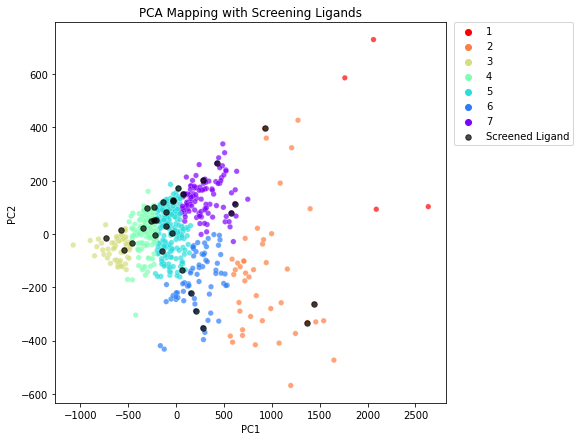

In [12]:
# Assign afterscreen labels to the original UMAP data from df_smiles_kraken for superimposing
dfs['pc2']['Afterscreen'] = df_projection['Afterscreen']

# Plot the PCA mapping
plt.figure(figsize=(7, 7))
sns.scatterplot(x="PC1", y="PC2", data=dfs['pc2'], s=30, alpha=0.7, linewidth=0.25,palette='rainbow_r', legend='full',
  hue=df_projection['PCA_Cluster'])

# Overlay the Afterscreen data by superimposing it on the same plot
# Increase the size of points for Afterscreen data
afterscreen_data = dfs['pc2'][dfs['pc2']['Afterscreen'] == 1]
plt.scatter(x=afterscreen_data['PC1'], y=afterscreen_data['PC2'],
            s=30, alpha=0.7, color='black', label='Screened Ligand')

# Set title and adjust the legend
plt.title("PCA Mapping with Screening Ligands")
plt.legend(bbox_to_anchor=(1.02, 1), loc=2, borderaxespad=0.)
plt.show()

UMAP Mapping

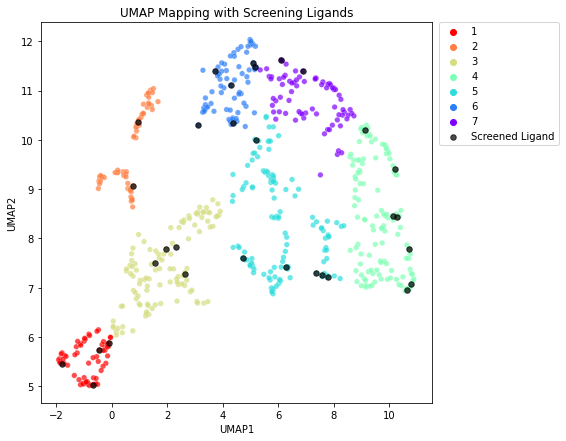

In [13]:
# Assign afterscreen labels to the original UMAP data from df_smiles_kraken for superimposing
dfs['umap2']['Afterscreen'] = df_projection['Afterscreen']

plt.figure(figsize=(7, 7))
sns.scatterplot(x="UMAP1", y="UMAP2", data=dfs['umap2'], s=30, alpha=0.7, linewidth=0.25,palette='rainbow_r', legend='full',
  hue=df_projection['UMAP_Cluster'])

# Overlay the Afterscreen data by superimposing it on the same plot
# Increase the size of points for Afterscreen data
afterscreen_data = dfs['umap2'][dfs['umap2']['Afterscreen'] == 1]
plt.scatter(x=afterscreen_data['UMAP1'], y=afterscreen_data['UMAP2'],
            s=30, alpha=0.7, color='black', label='Screened Ligand')

# Set title and adjust the legend
plt.title("UMAP Mapping with Screening Ligands")
plt.legend(bbox_to_anchor=(1.02, 1), loc=2, borderaxespad=0.)
plt.show()


Both Screening and Validation set superimposed on UMAP with colormap to dictate reactivity

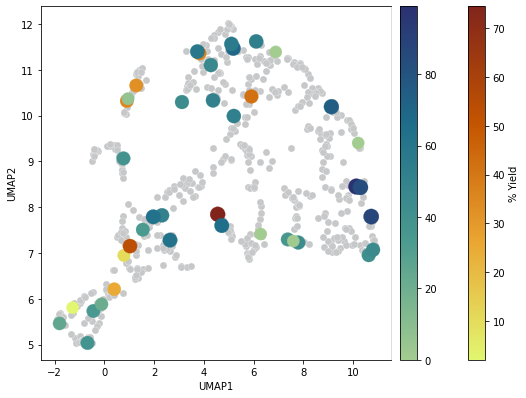

In [15]:
# Create color maps for the scatter plot
blue_green_cmap = LinearSegmentedColormap.from_list(
    'blue_to_green',
    ['#a3cc90', '#4b9b90', '#1e6d8a',  '#2c3172']
)
red_yellow_cmap = LinearSegmentedColormap.from_list(
    'red_to_yellow',
    ['#e2f670','#eaa632',  '#c45500','#81251c']
)

plt.figure(figsize=(9, 6.5))

#plt.title("UMAP Mapping with Screening and Validation Ligands")
sns.scatterplot(x="UMAP1", y="UMAP2", data=dfs['umap2'], s=50, alpha=1, linewidth=0.25, color='#c7c8c9')

# Get the current axis
ax = plt.gca()
# Set the right edge color to grey
ax.spines['right'].set_edgecolor('#d4d4d4')

# Scatter plot of the validation data
scatter = plt.scatter(x="UMAP1", y="UMAP2", data=dfs['umap2'],
                      s=df_projection['Valid_Yield']+150,  
                      c=df_projection['Valid_Yield'],  
                      cmap=red_yellow_cmap,  
                      alpha=1,  
                      linewidth=0.25)

# Add a colorbar
cbar = plt.colorbar(scatter, label='% Yield', pad=0.01)

# Scatter plot of the screening data
scatter = plt.scatter(x="UMAP1", y="UMAP2", data=dfs['umap2'],
                      s=df_projection['Yield']+150,  
                      c=df_projection['Yield'],  
                      cmap=blue_green_cmap,  
                      alpha=1,  
                      linewidth=0.25)

# Add a colorbar
cbar = plt.colorbar(scatter,  pad=0.02)

plt.show()
